In [12]:
import numpy as np
import matplotlib.pyplot as plt

このノートではホップフィールドネットワーク(Hopfiled Network)の簡単な例と, 画像を記憶・想起させるプログラムの実装について示す.
# 1. ホップフィールドネットワークの簡単な例
ホップフィールドネットワークはパターンを記憶する教師なし学習の手法である. このネットワークは記憶モードと想起モードの2つから構成される.  
(1)記憶モード
記憶したいベクトル$a_1,a_2,\cdots,a_P$として, 重み$W$を用いてベクトルを記憶する. 
重み$W$は次で計算される. ただし対角成分(自己想起と呼ばれる)は0として,符号化する. ここでは0以上のとき1, 0未満のとき-1で符号化する. ${}^ta_p$はベクトル$a_p$の転置を表す.
$$W = \sum_{p=1}^{P} a_p{}^ta_p$$

(2)想起モード  
想起モードではノイズを含むパターンを与えて最も近いパターンを出力する自己想起を行う. ノイズを含む入力パターン$X_{init}$とする. このとき次の手順で自己想起を行う.
1. $X_{pred} ← X_{init}$とする.
2. 次の計算をループする.
    1. $X ← WX_{pred}$とする.
    2. $X$を符号化する.
    3. $X$と$X_{pred}$の全ての要素が一致したときループを終了する.
    4. $X_{pred} ← X$とする.
3. $X$を想起結果として処理を終了する. 

以上の理論を踏まえてホップフィールドネットワークの計算過程を簡単な例で追ってみる.

## 1.1 記憶するベクトルの定義

In [2]:
# 2つのベクトルを記憶する
a1 = np.array([[1,1,-1,1]]).T
a2 = np.array([[1,-1,1,-1]]).T
print(a1.shape)

(4, 1)


## 1.2 学習モード

In [3]:
# 重みを計算
W = np.dot(a1,a1.T)+np.dot(a2,a2.T)
W_shape = W.shape[0]
W[range(W_shape),range(W_shape)] = 0 # 対角成分に0を代入
W

array([[ 0,  0,  0,  0],
       [ 0,  0, -2,  2],
       [ 0, -2,  0, -2],
       [ 0,  2, -2,  0]])

## 1.3 想起モード

In [4]:
# 入力ベクトル
X_init = np.array([[-1,-1,1,-1]]).T

X_pred = X_init
while(True):
    X = np.dot(W,X_pred)
    X = np.sign(X) # 符号化
    X[X==0] = 1 # 0のとき符号を1にする
    print(X)
    if np.all(X==X_pred):
        break
    X_pred=X

[[ 1]
 [-1]
 [ 1]
 [-1]]
[[ 1]
 [-1]
 [ 1]
 [-1]]


$a_2$にノイズを付加した(-1,-1,1,-1)というベクトルを与えると$a_2$が想起されていることがわかる.

# 2. 画像の記憶・想起の実装
5x5のランダムに生成した画像を記憶させて, ノイズを付加した画像を想起させてみる. 2次元画像を扱うことはできないから1次元行列に変換する.

In [54]:
def gen_img(size=5,num=3):
    """Generate image 
    
    Args:
    size : size of image, default=5
    num : number of generating image, default=3
    
    Returns:
    list of images
    """
    img_list = []
    for i in range(num):
        # 0または1の乱数を生成して, -1または1に変換
        img_list.append(np.random.randint(0,2,(size,size))*2-1)
    return img_list

def show_img(img_list,label_list=[]):
    """Drawing image
    
    Args:
    img_list : list of images
    label_list : list of label name, if none named "image1","image2", ...
    
    Returns:
    None
    """
    
    list_len = len(img_list)
    label_len = len(label_list)
    plt.figure(figsize=(8,6),facecolor="white")
    for i in range(list_len):
        plt.subplot(1,list_len,i+1)
        plt.imshow(img_list[i])
        if label_len==0:
            plt.title("image"+str(i+1))
        else:
            plt.title(label_list[i])
    plt.show()

def learn_mode(img_list_1d):
    """caluculate weight
    
    Args:
    img_list_1d : list of image(1d)
    
    Returns:
    W : weight
    """
    squared_list = list(map(lambda img: np.dot(img,img.T), img_list_1d)) # 各ベクトルの2乗を計算
    W = sum(squared_list) # shape=(size,size)
    W[range(W_shape),range(W_shape)] = 0 # 対角成分に0を代入
    return W

def remember_mode(W,remember_vec):
    """remember vector
    
    Args:
    W : weight
    remember_vec : remember pattern(vector)
    
    Returns:
    remember result
    """
    
    X_pred = remember_vec.copy()
    while(True):
        X = np.dot(W,X_pred)
        X = np.sign(X) # 符号化
        X[X==0] = 1 # 0のとき符号を1にする
        if np.all(X==X_pred):
            break
        X_pred=X
    return X

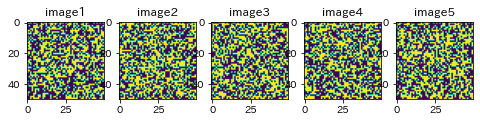

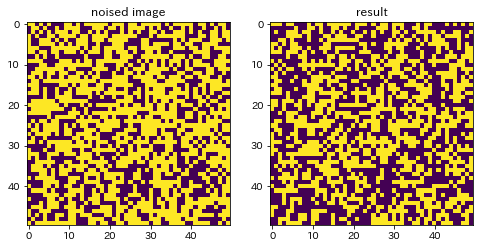

In [59]:
size = 10 # 画像の大きさ
num = 5 # 記憶パターン枚数
# 記憶パターン画像生成
img_list = gen_img(size,num)
show_img(img_list)
# 画像を1次元配列に変換
img_list_1d = list(map(lambda img: img.reshape(-1,1), img_list))
# 記憶モード
W = learn_mode(img_list_1d)
# 連想モード
remember_img = img_list[0] # 連想するimage
noise = np.random.randint(-2,3,(size,size)) # ノイズを生成
noised_img = np.sign(remember_img+noise) # 画像を符号化
noised_img[noised_img==0]=1 # 0のとき符号を1にする
noised_vec = noised_img.reshape(-1,1) # 1次元配列に変換
result_1d = remember_mode(W,noised_vec) # 想起
result_img = result_1d.reshape(size,size) # 1次元配列を画像に戻す
show_img([noised_img,result_img],["noised image","result"])